In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import Normalize
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
import requests
from descartes import PolygonPatch

%matplotlib inline

/usr/local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Utility Outage Analysis

I stumbled across this article: http://insideenergy.org/2014/08/18/data-explore-15-years-of-power-outages/, which contained a dataset of utility outages over the past 15 years from 2000 - 2014. I came up with a few questions as a fun analyitcs exercise to answer, and used this an a chance to practice some data cleaning and visualization.

## Questions to answer

1. what is the most common outage event type
2. where does the most common event happen (region)
3. what was the shortest outage?
4. what was the longest outage?
5. what is the average number of customers affected during an outage?
6. how long is the average outage?
7. what utility has had the most outages?
8. what utility has has the most affected customers?
9. what region does this occur in?
10. generate a map showing the utility outage events that occurred in 2016

## Answers
analysis and code are in the cells below


1. <b> most common event type: </b> severe weather with 866 tagged instances, second is vandalism with 346
* <b> where does most common event happen: </b> michigan with 79 reported events, second Virginia, third Pennsyl. On the opposite end, Wyoming, Arizona, Montana, Utah, New Mexico all had only 1 reported outage due to severe weather
* <b> shortest outage: </b> shortest outage in the set is 1 hr, with 115 reported instances of this duration
* <b> longest outage: </b> 131 days, 6 hours that affected Michigan and Iowa from June to Oct 2013. Was the result of suspected cyber attack and had an unknown number of affected customers
* <b> average number of customers affected in outage: </b> 163,791 people
* <b> average outage length: </b> 2 days, 6 hours and 35 mins
* <b> most affected utility by number of outages: </b> ISO New England listed as most frequent respondent, does not go into utility level information with 47 instances. Next is Puerto Rico Electric Power Authority (45), PacifiCorp (44) and Southern Company (43). We would need a lot of data clean-up to get a more accurate picture, example PG&E would be more common but is listed as several different names. 
* <b> most affected utility by number of customers: </b> PG&E is still top in terms of affected people (8,031,860), Duke Energy Midwest is next with (6,224,793) and Southern Company taking the number 3 spot (5,998,908).
* <b> most affected region: </b> RFC is the worst region (421 instances), followed by WECC (399) and SERC (265). From Wikipeadia: "The RF region is situated within the Eastern Interconnection and covers territory stretching from the Eastern United States to the lower Great Lakes, including all or portions of New Jersey, Pennsylvania, Delaware, Maryland, Virginia, West Virginia, Ohio, Michigan, Kentucky, Tennessee, Indiana, Illinois, Wisconsin, and the District of Columbia." It actually makes sense this is highest outage region due to severe weather near the Great Lakes and east coast

In [22]:
#you can download the outage data as csv from the Googledrive:
#https://docs.google.com/spreadsheets/d/1AdxhulfM9jeqviIZihuODqk7HoS1kRUlM_afIKXAjXQ/edit
file_name = 'grid_outage.csv' 

In [23]:
df = pd.read_csv(file_name)

In [24]:
df.head()

,Event Description,Year,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Respondent,Geographic Areas,NERC Region,Demand Loss (MW),Number of Customers Affected,Tags
0,Severe Weather - Thunderstorms,2014,6/30/2014,8:00 PM,7/2/2014,6:30 PM,Exelon Corporation/ComEd,Illinois,RFC,Unknown,"420,000","severe weather, thunderstorm"
1,Severe Weather - Thunderstorms,2014,6/30/2014,11:20 PM,7/1/2014,5:00 PM,Northern Indiana Public Service Company,North Central Indiana,RFC,Unknown,"127,000","severe weather, thunderstorm"
2,Severe Weather - Thunderstorms,2014,6/30/2014,5:55 PM,7/1/2014,2:53 AM,We Energies,Southeast Wisconsin,MRO,424,"120,000","severe weather, thunderstorm"
3,Fuel Supply Emergency - Coal,2014,6/27/2014,1:21 PM,Unknown,Unknown,We Energies,Wisconsin,MRO,Unknown,Unknown,"fuel supply emergency, coal"
4,Physical Attack - Vandalism,2014,6/24/2014,2:54 PM,6/24/2014,2:55 PM,Tennessee Valley Authority,"Nashville, Tennessee",SERC,Unknown,Unknown,"vandalism, physical"


The utility outage dataset has a lot of variation in what we might assume are the same entries across almost every column. There are also a lot of entries missing in the date columns. 

Below I'm modifying the data in the columns to make it easier for analysis.

In [25]:
df['Date Event Began'] = [str(i).upper() for i in df['Date Event Began']]
df['Date Event Began'] = ['1/1/1970' if i == 'NAN' else i for i in df['Date Event Began']]
df['Date Event Began'] = ['1/1/1970' if i == 'UNKNOWN' else i for i in df['Date Event Began']]
df['Date Event Began'] = ['1/1/1970' if i == 'ONGOING' else i for i in df['Date Event Began']]

In [26]:
df['Time Event Began'] = [str(i).replace('.','').upper() for i in df['Time Event Began']]
df['Time Event Began'] = [str(i).replace('NOON','PM').upper() for i in df['Time Event Began']]
df['Time Event Began'] = ['12:00 PM' if i == 'NAN' else i for i in df['Time Event Began']]
df['Time Event Began'] = ['12:00 AM' if i == 'MIDNIGHT' else i for i in df['Time Event Began']]
df['Time Event Began'] = ['6:00 PM' if i == 'EVENING' else i for i in df['Time Event Began']]
df['Time Event Began'] = ['12:00 PM' if i == 'ONGOING' else i for i in df['Time Event Began']]

In [27]:
df['Date of Restoration'] = ['1/1/1970' if i == 'ONGOING' else i for i in df['Date of Restoration']]
df['Date of Restoration'] = [str(i).upper() for i in df['Date of Restoration']]
df['Date of Restoration'] = ['1/1/1970' if i == 'NAN' else i for i in df['Date of Restoration']]
df['Date of Restoration'] = ['1/1/1970' if i == 'UNKNOWN' else i for i in df['Date of Restoration']]
df['Date of Restoration'] = ['1/1/1970' if i == 'ONGOING' else i for i in df['Date of Restoration']]

In [28]:
df['Time of Restoration'] = [str(i).replace('.','').upper() for i in df['Time of Restoration']]
df['Time of Restoration'] = [str(i).replace('NOON','PM').upper() for i in df['Time of Restoration']]
df['Time of Restoration'] = [str(i).replace('00A','00 AM').upper() for i in df['Time of Restoration']]
df['Time of Restoration'] = ['12:00 PM' if i == 'NAN' else i for i in df['Time of Restoration']]
df['Time of Restoration'] = ['12:00 PM' if i == 'UNKNOWN' else i for i in df['Time of Restoration']]
df['Time of Restoration'] = ['12:00 PM' if i == 'ONGOING' else i for i in df['Time of Restoration']]

In [29]:
df['TimeStart'] = df['Date Event Began']+' '+ df['Time Event Began']
df['TimeEnd'] = df['Date of Restoration']+' '+ df['Time of Restoration']

In [30]:
newtime_list = []
try:
    for i in df.TimeStart:
        if 'AM' not in i and 'PM' not in i:
            i = i + ' PM' #OK becacuse there is only one site with this condition and it is PM
        splitdate = i.split(' ')
        date = splitdate[0]
        hour = splitdate[1].split(':')[0]
        indicator = splitdate[-1]
        newtime = date + ' ' + hour + ':00' + ' ' + indicator
        if len(newtime) > 18:
            newtime = splitdate[0] + ' ' + splitdate[1].split(':')[0] + ':00 PM' #only one value with this condition
        newtime_list.append(newtime)
except:
    pass

In [31]:
df.TimeStart = pd.Series(newtime_list)
df.TimeStart = pd.to_datetime(df.TimeStart)

In [32]:
newtime_list = []
try:
    for i in df.TimeEnd:
        #if 'AM' not in i and 'PM' not in i:
        #    i = i + ' PM' #OK because there is only one site with this condition and it is PM
        splitdate = i.split(' ')
        date = splitdate[0]
        hour = splitdate[1].split(':')[0]
        if int(hour) > 12:
            newtime = date + ' ' + hour + ':00'
        elif int(hour) <= 12:
            indicator = splitdate[-1]
            newtime = date + ' ' + hour + ':00' + ' ' + indicator
        if len(newtime) > 18:
            newtime = splitdate[0] + ' ' + splitdate[1].split(':')[0] + ':00 PM' #only one value with this condition
        newtime_list.append(newtime)
except Exception as e:
    pass

In [33]:
df.TimeEnd = pd.Series(newtime_list)
df.TimeEnd = pd.to_datetime(df.TimeEnd)

setting the utility outage start time 1 day before end time for entries that had a missing start time value (an assumption I'm making)

In [34]:
for i,j in enumerate(df.TimeStart):
    if j.year == 1970:
        df.TimeStart[i] = df.TimeEnd[i] - datetime.timedelta(days=1);

setting the utility outage end time 1 day after start time for entires that had a missing end time (another assumption I'm making)

In [35]:
for i,j in enumerate(df.TimeEnd):
    if j.year == 1970:
        df.TimeEnd[i] = df.TimeStart[i] + datetime.timedelta(days=1);

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
df['TimeDelta'] = df.TimeEnd - df.TimeStart 
df['DayDiff'] = [i.days for i in df.TimeDelta]
df['SecondDiff'] = [i.seconds for i in df.TimeDelta]

need to remove days that have a negative day difference or second difference - most likely from user error when the data was entered

In [37]:
df_timefilt = df[(df.DayDiff >= 0) & (df.SecondDiff >= 0)]
print('removed: {0}'.format(len(df) - len(df_timefilt)))

removed: 28


need to remove outages that have a 0 day difference and 0 second difference

In [38]:
df_timefilt2 = df_timefilt[(df_timefilt.DayDiff != 0) | (df_timefilt.SecondDiff != 0)]
print('removed: {0}'.format(len(df_timefilt) - len(df_timefilt2)))

removed: 248


In [39]:
df_timefilt2.sort_values('TimeDelta',ascending=True).TimeDelta.value_counts().head()

0 days 01:00:00    115
0 days 02:00:00     81
0 days 03:00:00     65
0 days 04:00:00     62
1 days 00:00:00     53
Name: TimeDelta, dtype: int64

In [40]:
print('shortest outage: {0}'.format(
    df_timefilt2.sort_values('TimeDelta',ascending=True).TimeDelta.min()))

print('longest outage: {0}'.format(
    df_timefilt2.sort_values('TimeDelta',ascending=True).TimeDelta.max()))

print('average duration: {0}'.format(df_timefilt2.TimeDelta.mean()))

shortest outage: 0 days 01:00:00
longest outage: 131 days 06:00:00
average duration: 2 days 06:34:42.558139


In [41]:
df_timefilt2.sort_values('TimeDelta',ascending=False).head(5)

,Event Description,Year,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Respondent,Geographic Areas,NERC Region,Demand Loss (MW),Number of Customers Affected,Tags,TimeStart,TimeEnd,TimeDelta,DayDiff,SecondDiff
223,Suspected Cyber Attack,2013,6/21/2013,8:31 AM,10/30/2013,2:09 PM,ITC Transmission,"Michigan, Iowa",MRO,Unknown,Unknown,"vandalism, cyber",2013-06-21 08:00:00,2013-10-30 14:00:00,131 days 06:00:00,131,21600
93,Fuel Supply Emergency - Coal,2014,1/24/2014,12:00 AM,4/9/2014,11:53 AM,We Energies,Wisconsin,RFC,Unknown,Unknown,"fuel supply emergency, coal",2014-01-24 00:00:00,2014-04-09 11:00:00,75 days 11:00:00,75,39600
993,Transformer Faulted/Unit Tripped,2009,3/3/2009,6:48 AM,4/26/2009,6:05 AM,"New Covert Generating Company, LLC",Southwest Michigan,RFC,378,NaN,equipment failure,2009-03-03 06:00:00,2009-04-26 06:00:00,54 days 00:00:00,54,0
74,Fuel Supply Emergency - Coal,2014,2/7/2014,7:00 AM,3/21/2014,8:00 AM,"Somerset Operating Company, LLC",Niagara County New York,NPCC,675,Unknown,"fuel supply emergency, coal",2014-02-07 07:00:00,2014-03-21 08:00:00,42 days 01:00:00,42,3600
1483,Fire/Substation Multiple Public Appeals,2004,7/6/2004,6:00 AM,8/9/2004,12:00 PM,Salt River Project,"Metro Phoenix, Arizona",WECC,-,-,"wild fire, public appeal",2004-07-06 06:00:00,2004-08-09 12:00:00,34 days 06:00:00,34,21600


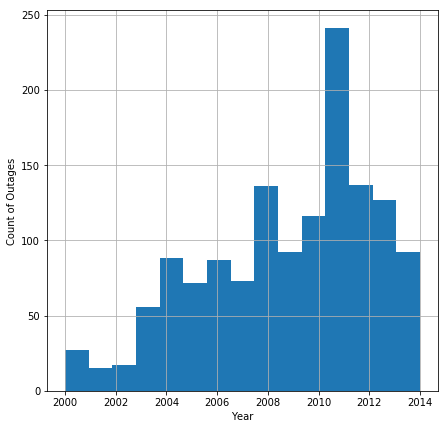

In [43]:
ax = df_timefilt2.Year.hist(bins=len(df_timefilt2.Year.value_counts()),figsize=(7,7))
ax.set_xlabel('Year');
ax.set_ylabel('Count of Outages');

Looking more closely at the specific events

In [44]:
df_evtfilt = df.copy()
df_evtfilt.Tags = [str(t) for t in df_evtfilt.Tags]

In [45]:
all_tag_dict = {}
for t in df_evtfilt.Tags:
    try:
        all_tags = t.split(',')
    except Exception as e:
        print(e)
    for tags in all_tags:
        newtag = tags.rstrip().lstrip()
        all_tag_dict[newtag] = all_tag_dict.get(newtag,0) + 1

In [46]:
df_events = pd.DataFrame.from_dict(all_tag_dict,orient='index')
df_events.columns = ['Count']
df_events.sort_values('Count',ascending=False)

,Count
severe weather,866
vandalism,346
thunderstorm,226
physical,200
winter storm,155
load shedding,131
hurricane/tropical storm,114
public appeal,103
wind,95
equipment failure,62


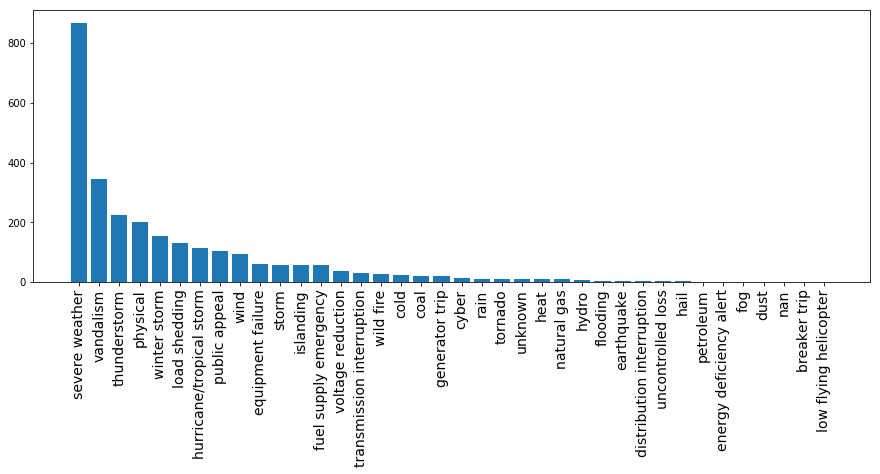

In [47]:
fig,ax = plt.subplots(figsize=(15,5))
plt.bar(range(len(df_events)),df_events.sort_values('Count',ascending=False).Count.values, align='center')
plt.xticks(range(len(df_events)), 
           df_events.sort_values('Count',ascending=False).index, rotation='vertical',fontsize=14);

Trying to see which states have the worst grid (in terms of outages and reliability)

In [56]:
df_evtfilt['MCFlag'] = [1 if 'severe weather' in t else 0 for t in df_evtfilt.Tags]
df_regionfilt = df_evtfilt[df_evtfilt.MCFlag == 1]
df_regionfilt['Geographic Areas'] = [g.lower() for g in df_regionfilt['Geographic Areas']];

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
all_region_dict = {}
for g in df_regionfilt['Geographic Areas']:
    try:
        all_locs = g.split(',')
    except Exception as e:
        print(e)
    for locs in all_locs:
        newloc = locs.rstrip().lstrip()
        all_region_dict[newloc] = all_region_dict.get(newloc,0) + 1

In [58]:
# from http://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
allstates = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [59]:
states = [s.lower() for s in allstates.values()]

In [60]:
all_region_dict = {}
for g in df_regionfilt['Geographic Areas']:
    for s in states:
        if s in g:
            all_region_dict[s] = all_region_dict.get(s,0) + 1

In [61]:
df_states = pd.DataFrame.from_dict(all_region_dict,orient='index')
df_states.columns = ['Count']
df_states.sort_values('Count',ascending=False)

,Count
michigan,79
virginia,69
pennsylvania,57
texas,52
ohio,52
maryland,48
indiana,47
north carolina,47
illinois,43
california,42


In [62]:
df_states.Count.sum()

1100

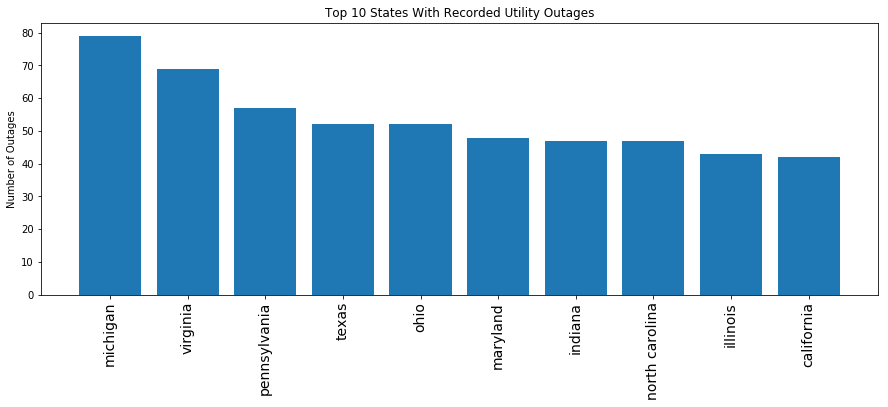

In [63]:
fig, ax = plt.subplots(figsize=(15,5))
plt.bar(range(len(df_states[0:10])), df_states.sort_values('Count',ascending=False).Count.values[0:10], align='center')
plt.xticks(range(len(df_states[0:10])), df_states.sort_values('Count',ascending=False).index[0:10],rotation='vertical',fontsize=14)
ax.set_ylabel('Number of Outages')
ax.set_title('Top 10 States With Recorded Utility Outages');

Now let's see if we can build a simple regression model for outages over time

In [64]:
df_cust = df_timefilt2[df_timefilt2['Number of Customers Affected'] != 'Unknown']
affect = []
for n in df_cust['Number of Customers Affected']:
    try:
        n = n.replace(',','')
        affect.append(int(n))
    except:
        affect.append(0)
df_cust['Affect'] = affect
df_cust = df_cust[df_cust.Affect != 0]
f = {'Year':'count','Affect':'sum'}
df_cust_agg = df_cust.groupby(['Year']).agg(f)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [65]:
print('largest outage event impacted: {0} people'.format(np.max(affect)))

largest outage event impacted: 4645572 people


In [66]:
df_cust_agg.rename(columns={'Year':'Count of outages','Affect':'Sum of customers impacted'},inplace=True)
df_cust_agg

,Count of outages,Sum of customers impacted
Year,,
2000,18,1707081
2001,5,1299490
2002,14,4882586
2003,38,12253810
2004,69,16958409
2005,57,16330113
2006,71,12240112
2007,47,6784818
2008,119,26066176


In [67]:
X = df_cust_agg.index.values
Y = df_cust_agg['Sum of customers impacted'].values
length = len(X)
x = X.reshape(length,1)
y = Y.reshape(length,1)
regr = linear_model.LinearRegression()
regr.fit(x, y)

/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

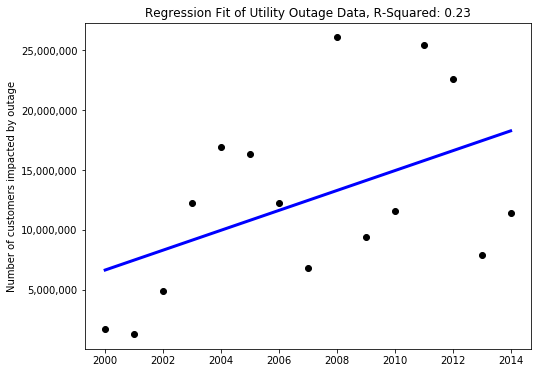

In [68]:
fig,ax = plt.subplots(figsize=(8,6))
plt.scatter(x, y, color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
ax.set_ylabel('Number of customers impacted by outage')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Regression Fit of Utility Outage Data, R-Squared: {0}'.format(np.round(regr.score(x,y),2)));

The linear regression does not fit the data well. However, even without the linear fit it _does_ look like there is a slight upward trend. This could be a result of bias in data recording / cleaning. For example, perhaps in the early years of our dataset (2000, 2001..) utilities did not report actual outages as often. Or perhaps the utility coverage in the early years of the dataset was lower than the later years.

Alternativley, it could reveal an alarming increase in grid vulnerability. We should try to normalize this against the population growth in the US for the same time range.

Finally, let's try to plot the data on a map by NERC region..

In [69]:
url = 'https://public.opendatasoft.com/api/records/1.0/search/?dataset=nerc-regions'
r = requests.get(url)
if r.status_code == 200:
    records = r.json()
else:
    print('bad request: {}'.format(r.status_code))

In [70]:
center = [r['fields']['geo_point_2d'] for r in records['records'] if len(r['fields']) > 2]
nerc_reg = df_timefilt2.groupby('NERC Region')['NERC Region'].count()
nerc_dict = {}
for n in nerc_reg.index:
    nerc_dict[n] = nerc_reg.ix[n];
nerc_regions = [r['fields']['nerc'] for r in records['records'] if len(r['fields']) > 2]
polys = [r['fields']['geo_shape'] for r in records['records'] if len(r['fields']) > 2]
nerc_value = [nerc_dict[n] for n in nerc_regions]
minima = min(nerc_value)
maxima = max(nerc_value)
norm = Normalize(vmin=minima, vmax=maxima)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Reds)
cols = []
for v in (nerc_value):
    cols.append(mapper.to_rgba(v))

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


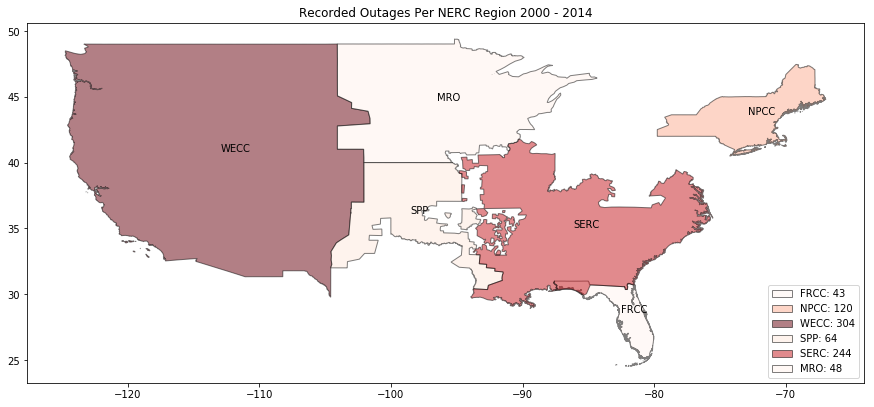

In [71]:
fig, ax = plt.subplots(figsize=(15,15))
cmap = plt.get_cmap('Blues')

for p,c,nr,nv,cent in zip(polys,cols,nerc_regions,nerc_value,center):
    lab = nr + ': ' + str(nv)
    ax = fig.gca() 
    ax.add_patch(PolygonPatch(p, fc=c, alpha=0.5, zorder=2,label=lab))
    ax.axis('scaled')
    plt.text(cent[1],cent[0],nr)
plt.legend(loc = 0)
plt.title('Recorded Outages Per NERC Region 2000 - 2014')
plt.show()

Clearing some missing regions. In order to do this plot we need to know where the NERC regions are in terms of latitude and longitude. I thought I struck gold here: https://public.opendatasoft.com/api/records/1.0/search/?dataset=nerc-regions, however it ended up missing a few of the regions. The goal above was to see how the NERC regions compare to each other in terms of reliability, however we should probably normalize this by customers per region or customers per region area before making any conclusions.

Either way, the above turned out to be an interesting exercise in using the PolygonPatch module from descartes to plot data onto co-ordinates. 